<a href="https://colab.research.google.com/github/Rhitabrat/deep-learning-CS510/blob/main/hw1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HW 1

#Import the libraries and load the data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List, Any
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [3]:
train_file_path = "/content/drive/Othercomputers/My MacBook Pro/PSU/Winter-2022/Deep Learning/Assignments/Assignment 1/FMNIST Dataset/fashion-mnist_train.csv"
test_file_path = "/content/drive/Othercomputers/My MacBook Pro/PSU/Winter-2022/Deep Learning/Assignments/Assignment 1/FMNIST Dataset/fashion-mnist_test.csv"

In [4]:
# let's see how our data looks like
data_train = pd.read_csv(train_file_path)
data_test = pd.read_csv(test_file_path)
data_train.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0


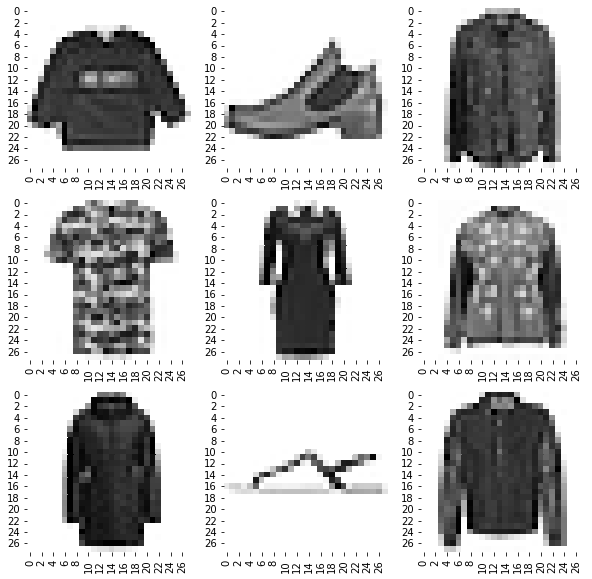

In [5]:
# visualizing some of the images

fig = plt.figure(figsize=(10,10))
for i in range(1,10):
    fig.add_subplot(3,3,i)
    sns.heatmap(np.array(data_train.iloc[i-1,1:]).reshape(28,28), cbar=False, cmap='Greys');

In [6]:
# getting the data ready for transforming

class FashionMNIST(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.labels = data.label.values
        self.images = data.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [7]:
# normalize the data and loading them for our model
data = pd.read_csv(train_file_path)
mean = np.array(data.iloc[:,1:]).flatten().mean()
std  = np.array(data.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_test  = FashionMNIST(data_test,transform=transf)
data_train = FashionMNIST(data_train,transform=transf)

# Neural Network

In [8]:
# some global variables
INPUT_SIZE = 784
OUTPUT_SIZE = 10

In [9]:
class NNetwork(torch.nn.Module):

    def __init__(self, hidden_size: List, activation):
        super().__init__()

        self.hidden_size = hidden_size

        self.activation = activation

        modules = []
        modules.append(nn.Linear(in_features=INPUT_SIZE, out_features=hidden_size[0]))
        modules.append(self.activation)

        for i in range(len(hidden_size) - 1):
            modules.append(nn.Linear(in_features=hidden_size[i], out_features=hidden_size[i + 1]))
            modules.append(self.activation)

        modules.append(nn.Linear(in_features=hidden_size[len(hidden_size) - 1], out_features=OUTPUT_SIZE))

        self.module_list = nn.ModuleList(modules=modules)

    def forward(self, x):

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        for f in self.module_list:
            x = x.to(device)
            x = f(x)

        x = x.to(device)
        return x

In [10]:
model = None
params = []
train_accuracy = []
test_accuracy = []
loss_train = []
loss_test = []
batch_size = 30
criterion = nn.CrossEntropyLoss()
data_train = data_train
data_test = data_test

In [11]:
class FashionModel():
    """
    FashionModel is the class object that encapsulates our model
    """

    def __init__(self, data_train, data_test, batch_size: int ) -> None:
        self.model = None
        self.params = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.loss_train = []
        self.loss_test = []
        self.batch_size = batch_size
        self.criterion = nn.CrossEntropyLoss()
        self.data_train = data_train
        self.data_test = data_test


    def test(self) -> None:
        """
        Evaluate a model
        """

        batch_length = len(self.test_loader)
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_id, (image, label) in enumerate(self.test_loader, start=1):
                image = image.view(image.shape[0], -1)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                image = image.to(device)
                label = label.to(device)
                outputs = self.model(image)

                if (batch_id / batch_length == 1):
                    loss = self.criterion(outputs, label)
                    self.loss_test.append(loss.item())
                    print(f"Testing Loss: {loss.item():.4f}   ", end=' ')

                predicted = torch.argmax(input=outputs, dim=1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

        accuracy = 100 * correct / total
        self.test_accuracy.append(accuracy)
        print(f"Testing Accuracy: {accuracy}%")

    def train(self, hidden_size: List, activation: Any, learn_rate: float, momentum: float, epochs: int) -> None:
        """
        Train a fully connected neural network classifier on a dataset of fashion images
        """
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = NNetwork(hidden_size=hidden_size, activation=activation)
        self.model.to(device)

        # Print Training Parameters
        print(f"Hidden Layers: {hidden_size}")
        print(f"Learning Rate: {learn_rate}")
        print(f"Activation:    {activation.__str__()}")
        print(f"Batch Size:    {self.batch_size}")
        print(f"Epochs:        {epochs}")
        print("------------------------------------------------------------------------------------------")

        self.train_loader = torch.utils.data.DataLoader(dataset=self.data_train, batch_size=self.batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.data_test, batch_size=self.batch_size, shuffle=True)

        optimizer = torch.optim.SGD(params=self.model.parameters(), lr=learn_rate, momentum=momentum)

        for epoch in range(1, epochs + 1):
            for batch_id, (image, label) in enumerate(self.train_loader):

                image = image.view(image.shape[0],-1)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                image = image.to(device)
                label = label.to(device)

                # Forward pass
                output = self.model(image)

                loss = self.criterion(output, label)
                loss = loss.to()
                # Initializing a gradient as 0 so there is no mixing of gradient among the batches
                optimizer.zero_grad()

                # Propagating the error backward
                loss.backward()

                # Prevent Gradient Explosion
                nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=2.0, norm_type=2)
                # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

                # Optimizing the parameters
                optimizer.step()

            print(f"Epoch {epoch}/{epochs}  Training Loss: {loss.item():.4f}   ", end=' ')
            # print(f"Epoch {epoch}/{epochs}  Train Loss: {loss.item():.4f}   Train Accuracy: {accuracy:.2f}%   ", end=' ')
            self.loss_train.append(loss.item())
            self.test()

        for i in self.model.parameters():
            self.params.append(i)

#Experiment 1

In [66]:
hidden_size = [1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 2

model_1 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_1.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.0593    Testing Loss: 0.8895    Testing Accuracy: 75.08%
Epoch 2/2  Training Loss: 0.5563    Testing Loss: 0.2708    Testing Accuracy: 78.47%


#Experiment 2

In [12]:
hidden_size = [1024, 1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 2

model_2 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_2.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.9611    Testing Loss: 1.0173    Testing Accuracy: 71.53%
Epoch 2/2  Training Loss: 0.6899    Testing Loss: 0.8594    Testing Accuracy: 76.51%


#Visualization

In [72]:
# %matplotlib inline
# %matplotlib notebook
# %matplotlib widget

# plt.rcParams['figure.figsize'] = [25, 10]
plt.rcParams['figure.figsize'] = [25, 5]


def display_model_visuals(model, title, hidden_size):

    # Plot Accuracy 
    plt.subplot(1,3,1)
    param_title = f"Hidden: {hidden_size}, batch: {model.batch_size}, η: {learn_rate}, φ: {activation.__str__()}"
    plt.plot(np.arange(epochs), model.test_accuracy, label='Test Accuracy')
    plt.title(f"{title}: Accuracy\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(np.arange(len(model.test_accuracy)), np.arange(1, len(model.test_accuracy) + 1))
    plt.legend();

    # Plot Cross-Entropy
    plt.subplot(1,3,2)
    param_title = f"Hidden: {hidden_size}, batch: {model.batch_size}, η: {learn_rate}, φ: {activation.__str__()}"
    plt.plot(np.arange(epochs), model.loss_train, label='Train Loss')
    plt.plot(np.arange(epochs), model.loss_test, label='Test Loss')
    plt.title(f"{title}: Cross Entropy Loss\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(len(model.loss_test)), np.arange(1, len(model.loss_test) + 1))
    plt.legend();

    # Create Confusion Matrix
    nb_classes = 10
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (image, classes) in enumerate(model.test_loader):
            image = image.view(image.shape[0], -1)
            outputs = model.model(image)
            _, preds = torch.max(outputs, dim=1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    cols = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag",
            "Ankle Boot"]
    plt.subplot(1,3,3)
    plt.title(f"{title}: Confusion Matrix\n{param_title}")
    sns.heatmap(pd.DataFrame(np.array(confusion_matrix), columns=cols, index=cols), cmap='Greys', annot=True, fmt='g');
    
    plt.show()

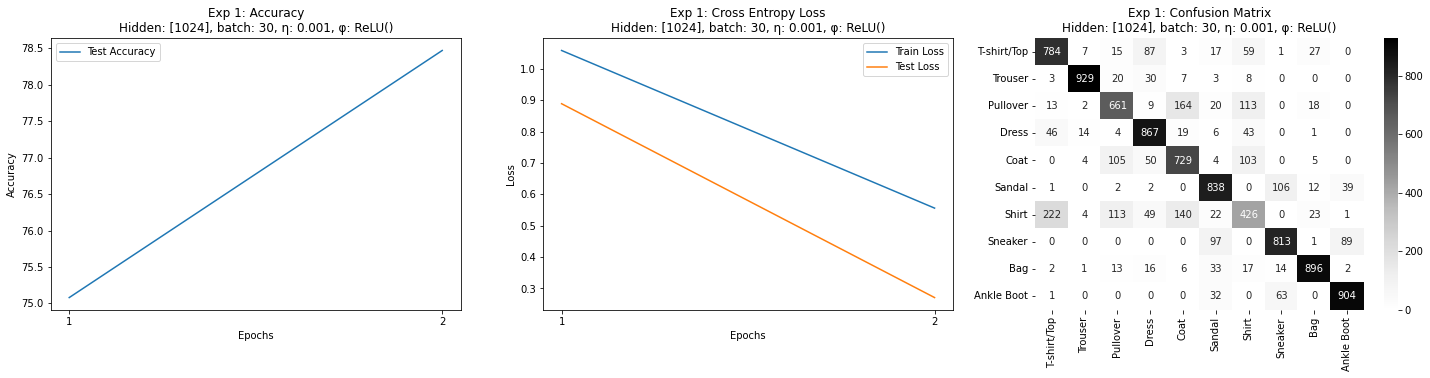

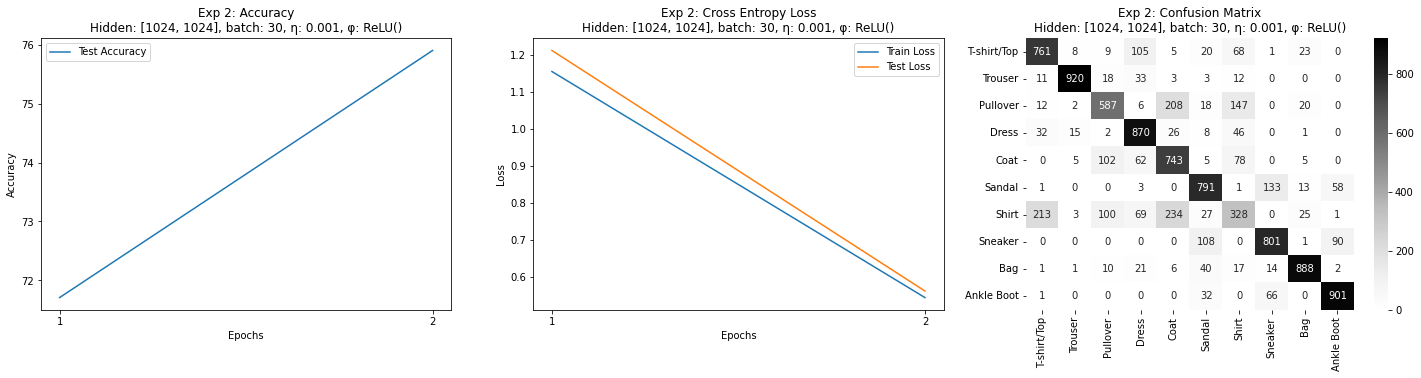

In [74]:
display_model_visuals(model=model_1, hidden_size=[1024], title="Exp 1")
display_model_visuals(model=model_2, hidden_size=[1024,1024], title="Exp 2")

3*4*2=24 Model Training - Started At: 01/17/2022 04:01:33
------------------------------------------------------------------------------------------
CASE: 01 Training Started: 01/17/2022 04:01:33
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    ReLU()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.5939    Testing Loss: 2.4390    Testing Accuracy: 39.63%
Epoch 2/2  Training Loss: 2.7890    Testing Loss: 0.0000    Testing Accuracy: 25.93%
Completed Case 1/24: 0:03:24.904790 Elapsed



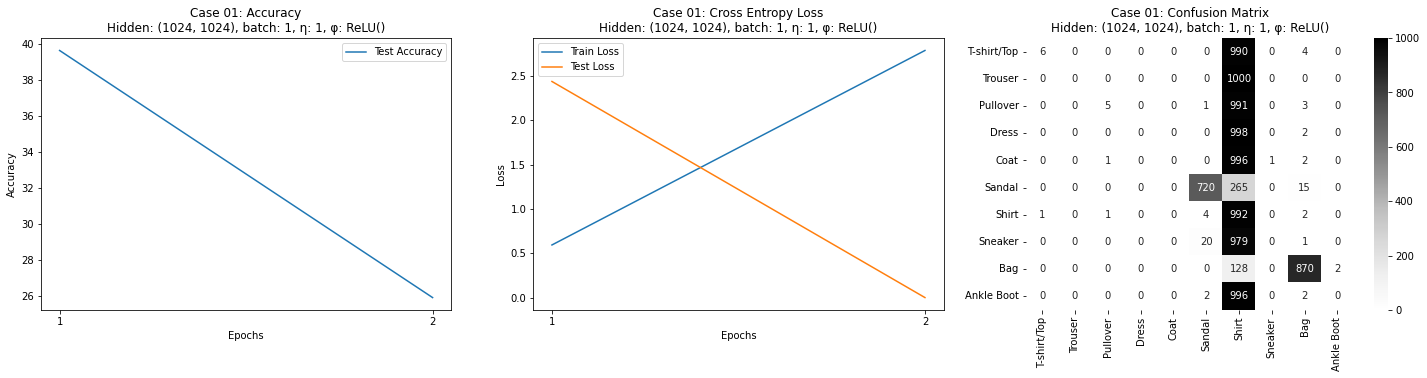

------------------------------------------------------------------------------------------
CASE: 02 Training Started: 01/17/2022 04:05:05
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.6016    Testing Loss: 0.0000    Testing Accuracy: 85.54%
Epoch 2/2  Training Loss: 0.0004    Testing Loss: 0.0028    Testing Accuracy: 87.96%
Completed Case 2/24: 0:03:23.965816 Elapsed



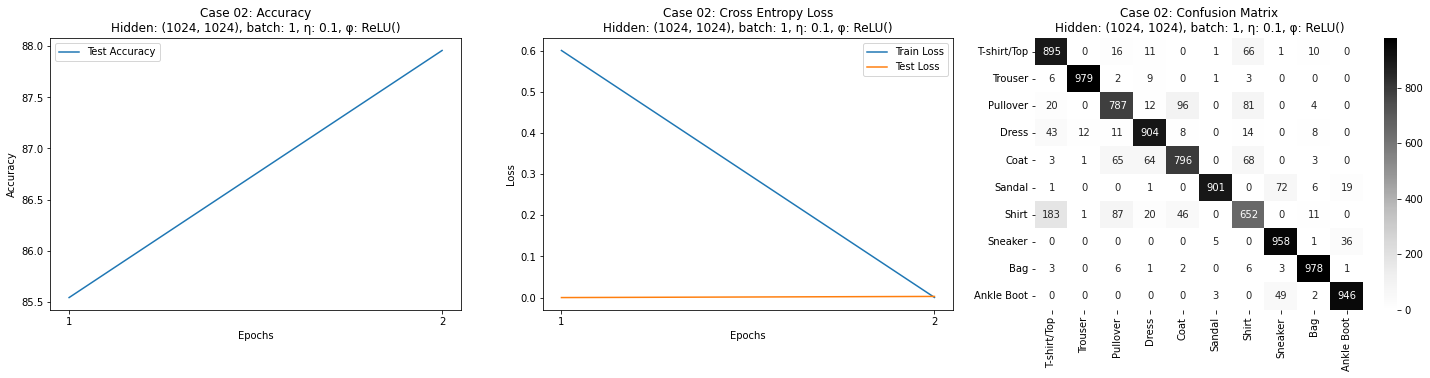

------------------------------------------------------------------------------------------
CASE: 03 Training Started: 01/17/2022 04:08:36
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.0003    Testing Loss: 0.0001    Testing Accuracy: 85.36%
Epoch 2/2  Training Loss: 1.7260    Testing Loss: 0.0000    Testing Accuracy: 87.08%
Completed Case 3/24: 0:03:25.380107 Elapsed



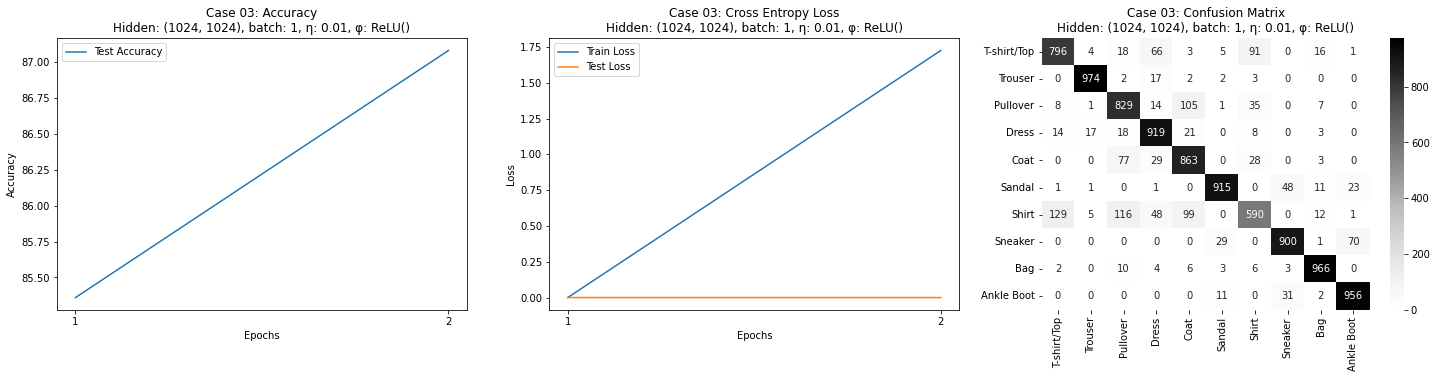

------------------------------------------------------------------------------------------
CASE: 04 Training Started: 01/17/2022 04:12:08
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.0046    Testing Loss: 2.4715    Testing Accuracy: 77.8%
Epoch 2/2  Training Loss: 0.0264    Testing Loss: 0.0024    Testing Accuracy: 80.95%
Completed Case 4/24: 0:03:24.823865 Elapsed



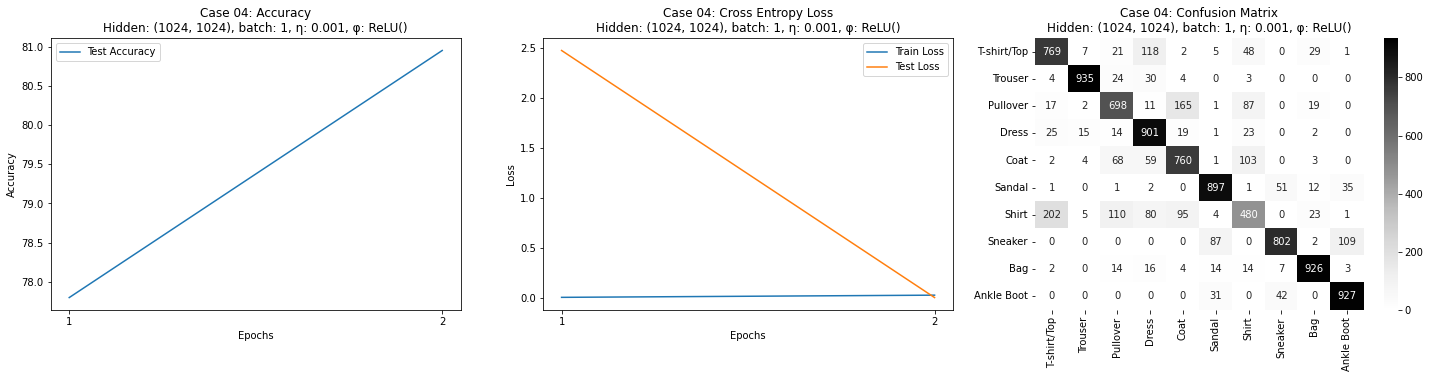

------------------------------------------------------------------------------------------
CASE: 05 Training Started: 01/17/2022 04:15:39
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 4.3181    Testing Loss: 0.0000    Testing Accuracy: 70.84%
Epoch 2/2  Training Loss: 0.0000    Testing Loss: 0.0003    Testing Accuracy: 64.7%
Completed Case 5/24: 0:03:22.829706 Elapsed



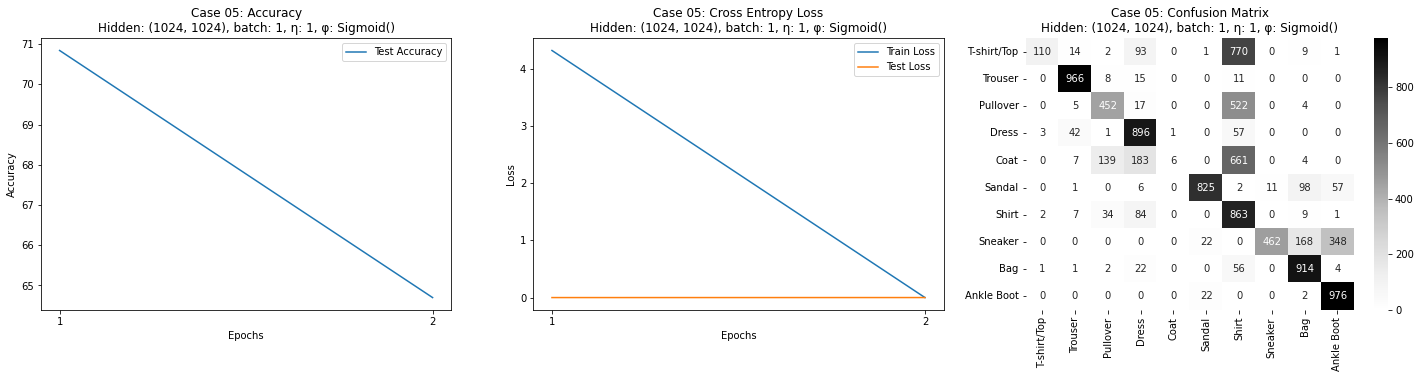

------------------------------------------------------------------------------------------
CASE: 06 Training Started: 01/17/2022 04:19:09
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.0324    Testing Loss: 0.0000    Testing Accuracy: 84.1%
Epoch 2/2  Training Loss: 2.3373    Testing Loss: 0.0144    Testing Accuracy: 86.51%
Completed Case 6/24: 0:03:22.853132 Elapsed



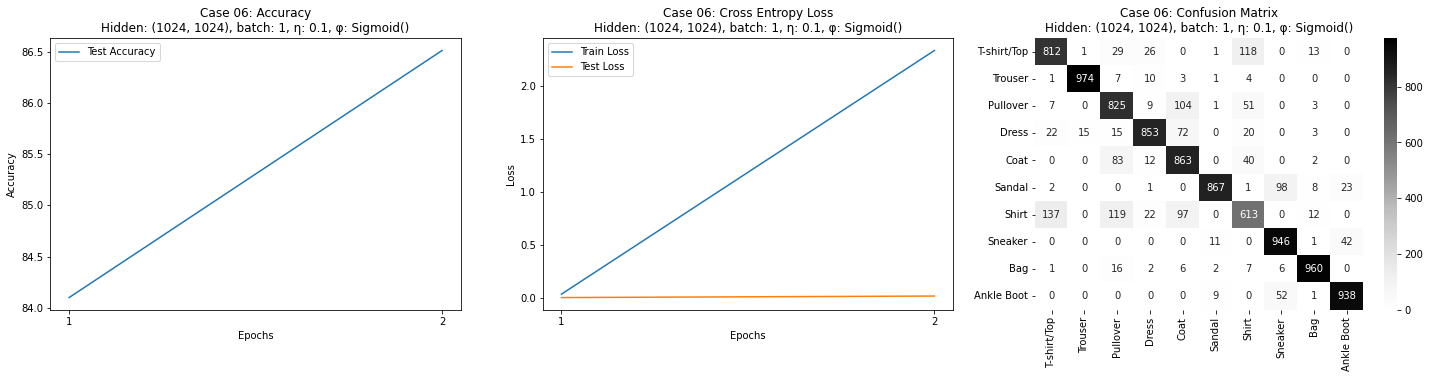

------------------------------------------------------------------------------------------
CASE: 07 Training Started: 01/17/2022 04:22:38
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.0003    Testing Loss: 0.0025    Testing Accuracy: 77.29%
Epoch 2/2  Training Loss: 0.0210    Testing Loss: 5.6062    Testing Accuracy: 81.21%
Completed Case 7/24: 0:03:23.422211 Elapsed



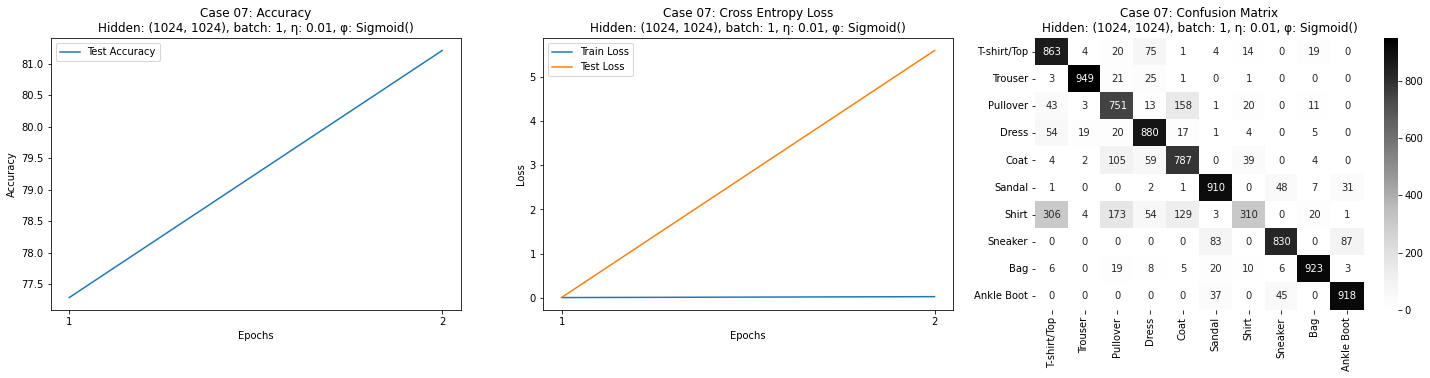

------------------------------------------------------------------------------------------
CASE: 08 Training Started: 01/17/2022 04:26:09
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 2.1531    Testing Loss: 1.6382    Testing Accuracy: 35.12%
Epoch 2/2  Training Loss: 0.2241    Testing Loss: 0.8537    Testing Accuracy: 54.48%
Completed Case 8/24: 0:03:22.773125 Elapsed



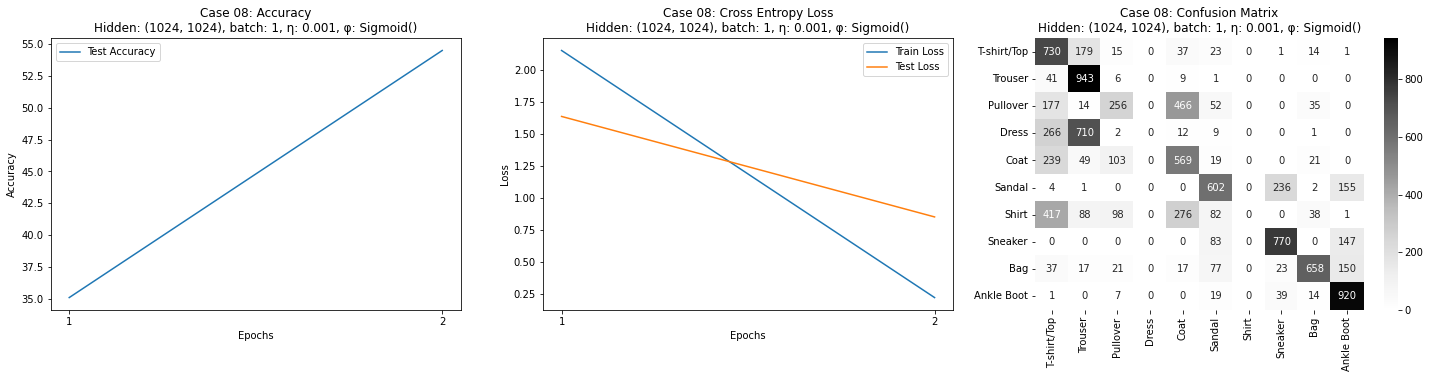

------------------------------------------------------------------------------------------
CASE: 09 Training Started: 01/17/2022 04:29:38
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    ReLU()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.3812    Testing Loss: 1.6359    Testing Accuracy: 37.28%
Epoch 2/2  Training Loss: 1.1076    Testing Loss: 1.1280    Testing Accuracy: 48.69%
Completed Case 9/24: 0:00:40.296040 Elapsed



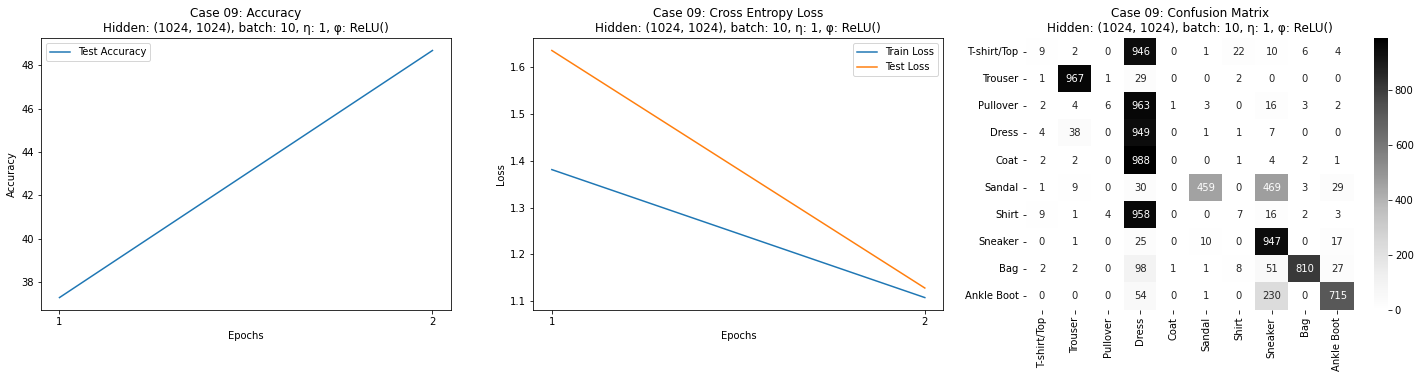

------------------------------------------------------------------------------------------
CASE: 10 Training Started: 01/17/2022 04:30:22
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.4621    Testing Loss: 0.5637    Testing Accuracy: 86.11%
Epoch 2/2  Training Loss: 0.3927    Testing Loss: 0.3572    Testing Accuracy: 87.14%
Completed Case 10/24: 0:00:40.208268 Elapsed



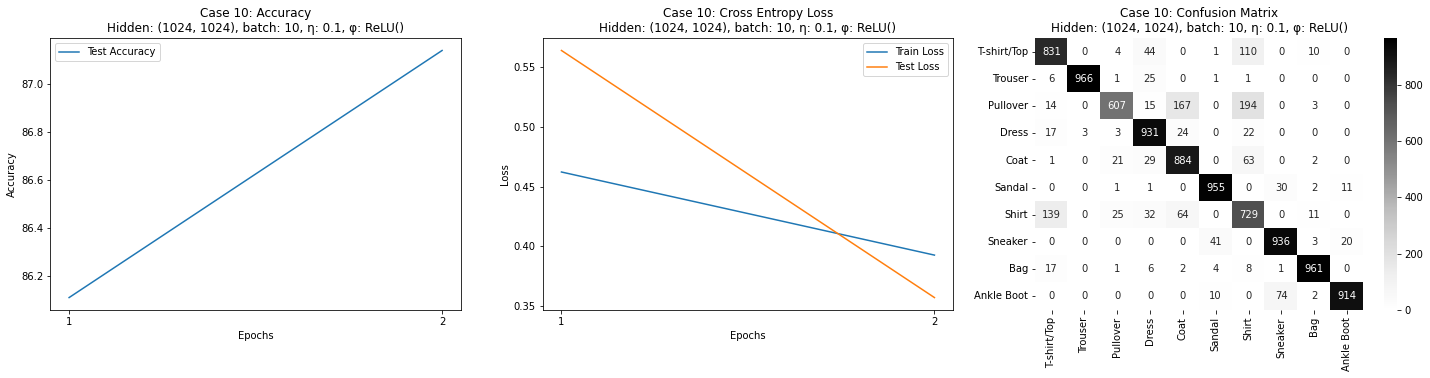

------------------------------------------------------------------------------------------
CASE: 11 Training Started: 01/17/2022 04:31:05
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.2371    Testing Loss: 0.2702    Testing Accuracy: 84.54%
Epoch 2/2  Training Loss: 0.0949    Testing Loss: 0.1527    Testing Accuracy: 86.32%
Completed Case 11/24: 0:00:40.617717 Elapsed



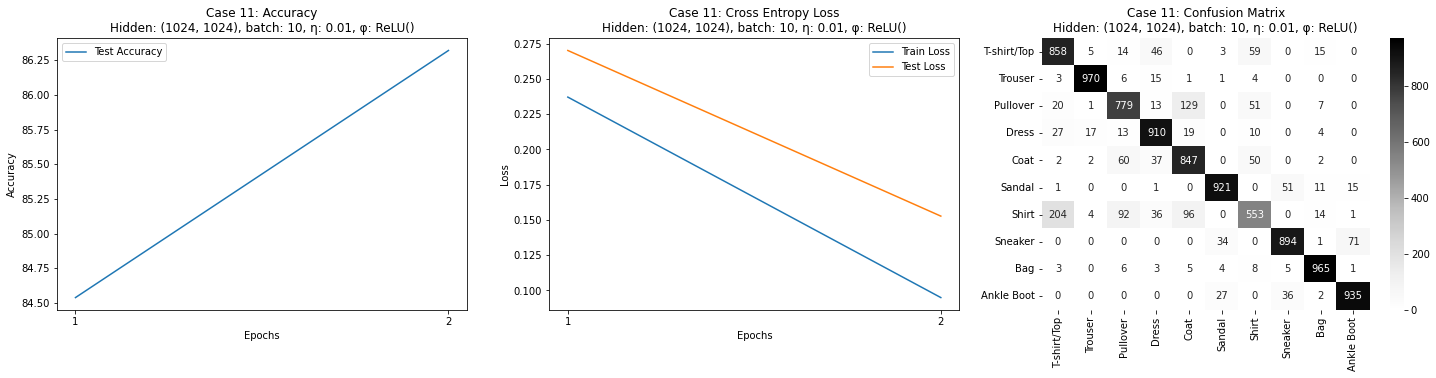

------------------------------------------------------------------------------------------
CASE: 12 Training Started: 01/17/2022 04:31:48
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.3113    Testing Loss: 0.7349    Testing Accuracy: 75.9%
Epoch 2/2  Training Loss: 0.2135    Testing Loss: 0.5424    Testing Accuracy: 79.53%
Completed Case 12/24: 0:00:40.302833 Elapsed



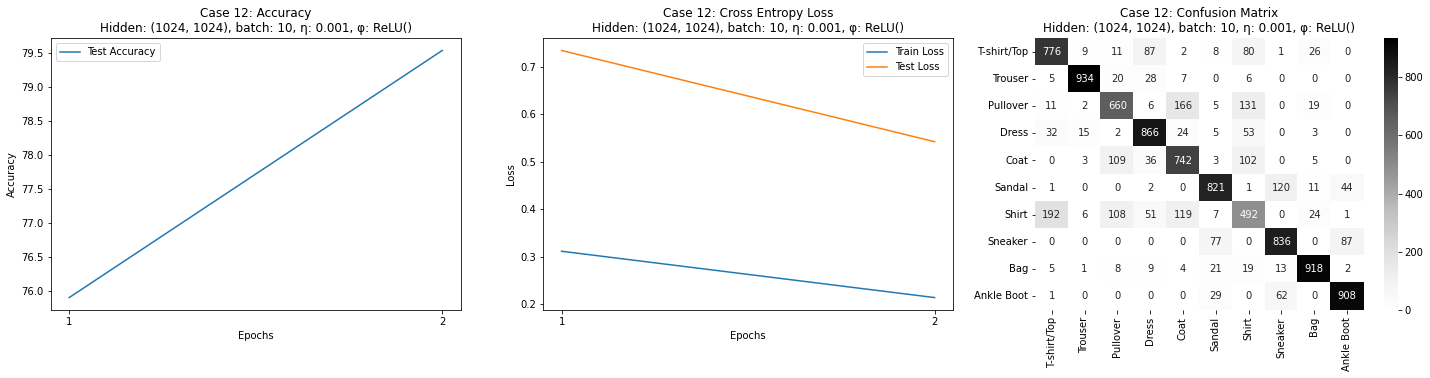

------------------------------------------------------------------------------------------
CASE: 13 Training Started: 01/17/2022 04:32:32
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.6207    Testing Loss: 0.3144    Testing Accuracy: 85.31%
Epoch 2/2  Training Loss: 0.1629    Testing Loss: 0.0583    Testing Accuracy: 86.11%
Completed Case 13/24: 0:00:40.663268 Elapsed



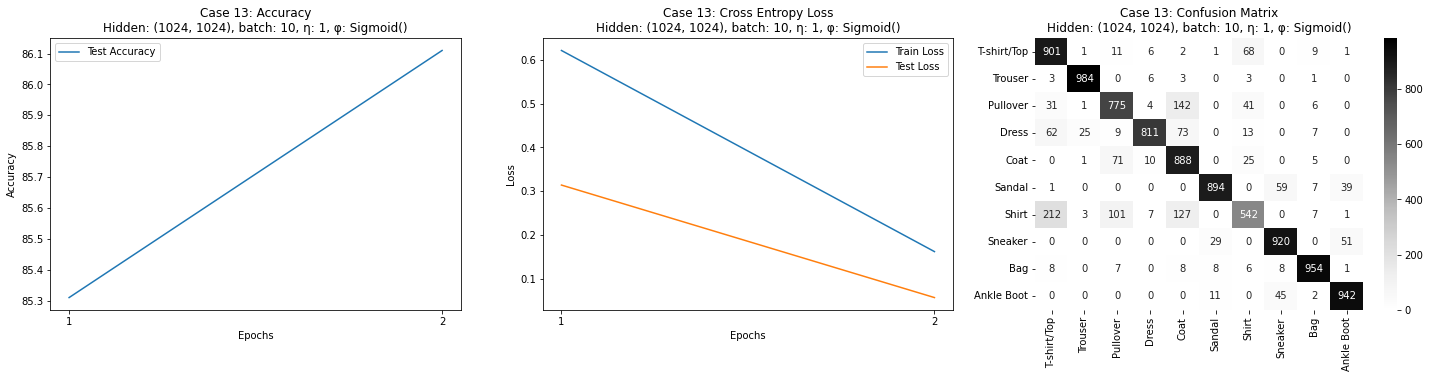

------------------------------------------------------------------------------------------
CASE: 14 Training Started: 01/17/2022 04:33:16
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.7057    Testing Loss: 0.8615    Testing Accuracy: 83.54%
Epoch 2/2  Training Loss: 0.3275    Testing Loss: 0.5064    Testing Accuracy: 84.28%
Completed Case 14/24: 0:00:40.259508 Elapsed



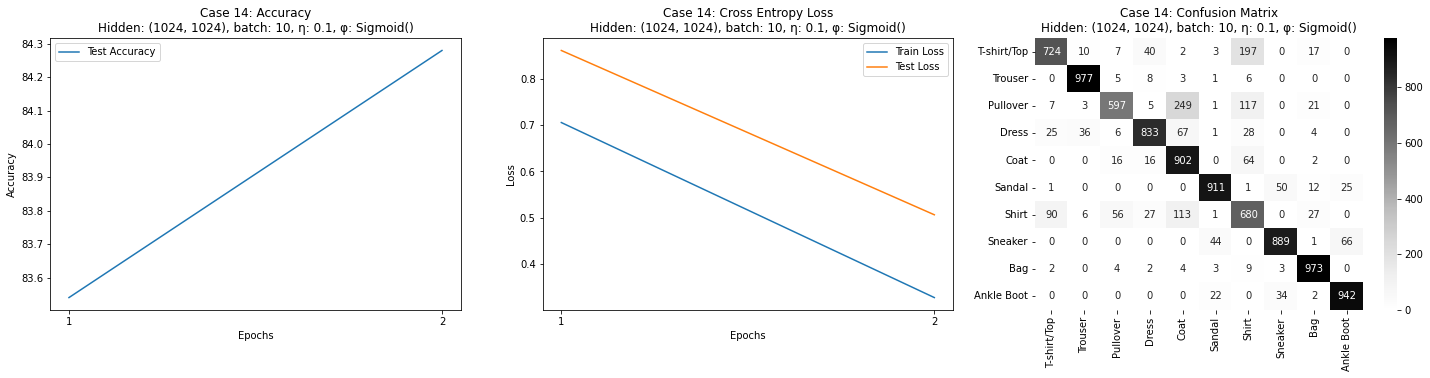

------------------------------------------------------------------------------------------
CASE: 15 Training Started: 01/17/2022 04:33:59
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.0557    Testing Loss: 0.5880    Testing Accuracy: 68.14%
Epoch 2/2  Training Loss: 1.1797    Testing Loss: 0.3437    Testing Accuracy: 74.87%
Completed Case 15/24: 0:00:40.437874 Elapsed



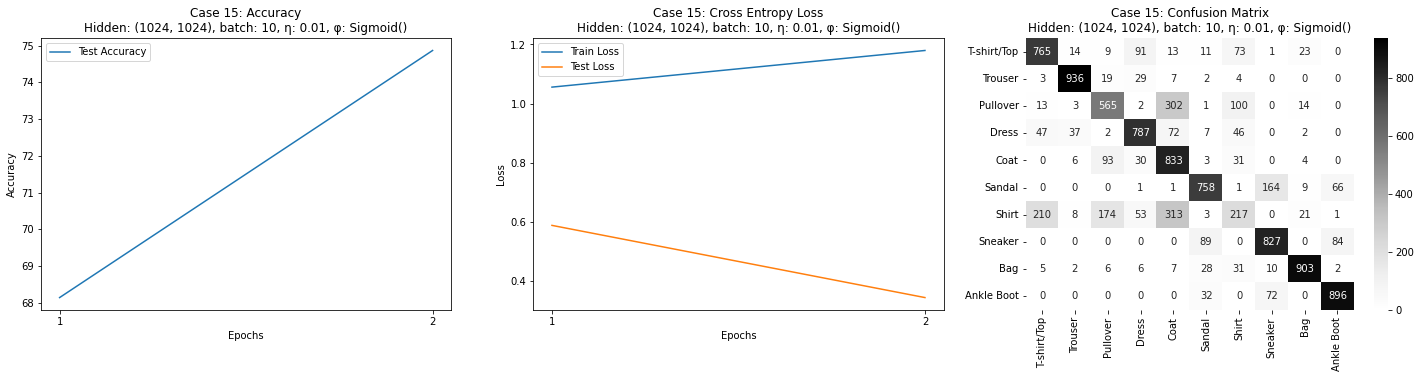

------------------------------------------------------------------------------------------
CASE: 16 Training Started: 01/17/2022 04:34:43
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 2.2693    Testing Loss: 2.2495    Testing Accuracy: 28.26%
Epoch 2/2  Training Loss: 2.1915    Testing Loss: 2.1806    Testing Accuracy: 40.76%
Completed Case 16/24: 0:00:39.986625 Elapsed



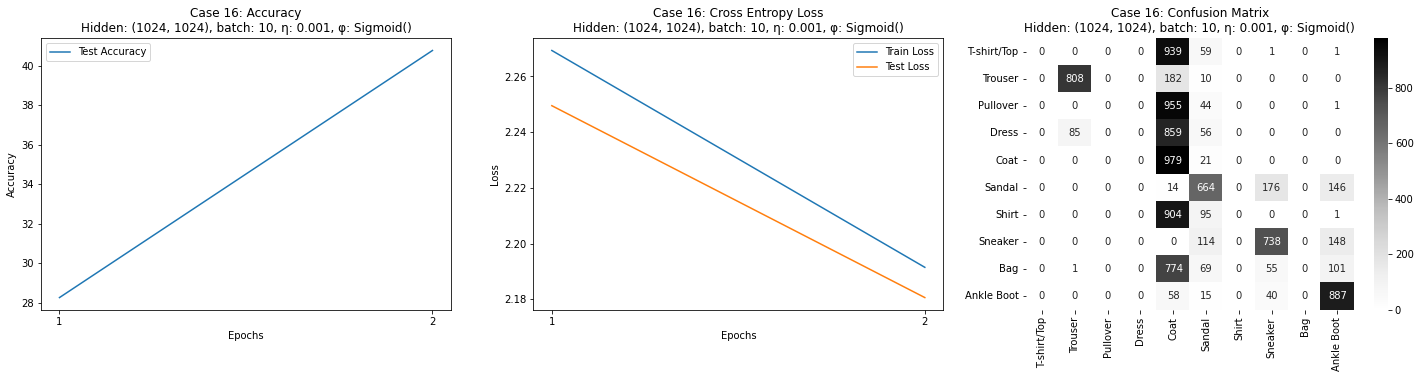

------------------------------------------------------------------------------------------
CASE: 17 Training Started: 01/17/2022 04:35:26
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    ReLU()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.1838    Testing Loss: 0.8938    Testing Accuracy: 70.44%
Epoch 2/2  Training Loss: 0.5028    Testing Loss: 0.5612    Testing Accuracy: 78.28%
Completed Case 17/24: 0:00:21.729243 Elapsed



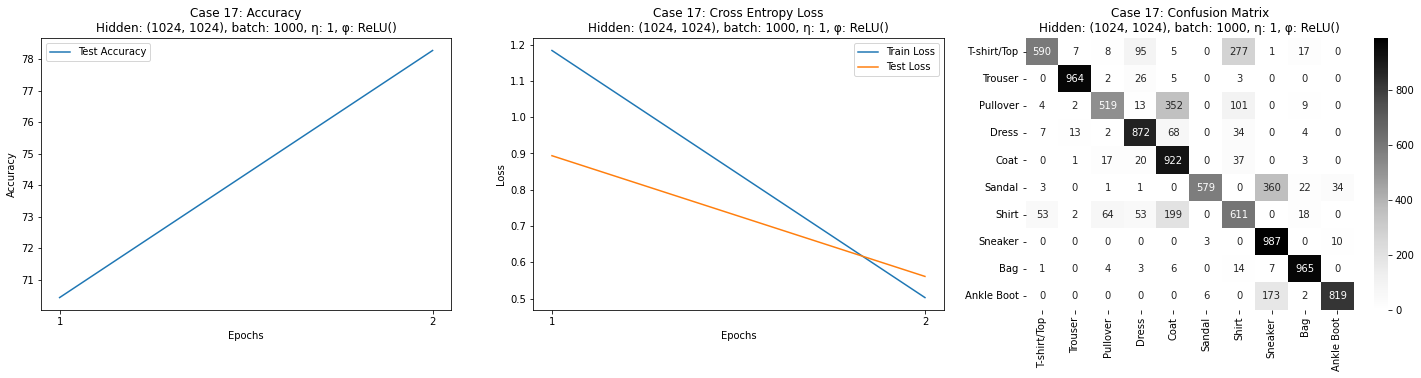

------------------------------------------------------------------------------------------
CASE: 18 Training Started: 01/17/2022 04:35:50
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.6278    Testing Loss: 0.6552    Testing Accuracy: 77.16%
Epoch 2/2  Training Loss: 0.5604    Testing Loss: 0.5090    Testing Accuracy: 79.78%
Completed Case 18/24: 0:00:21.557949 Elapsed



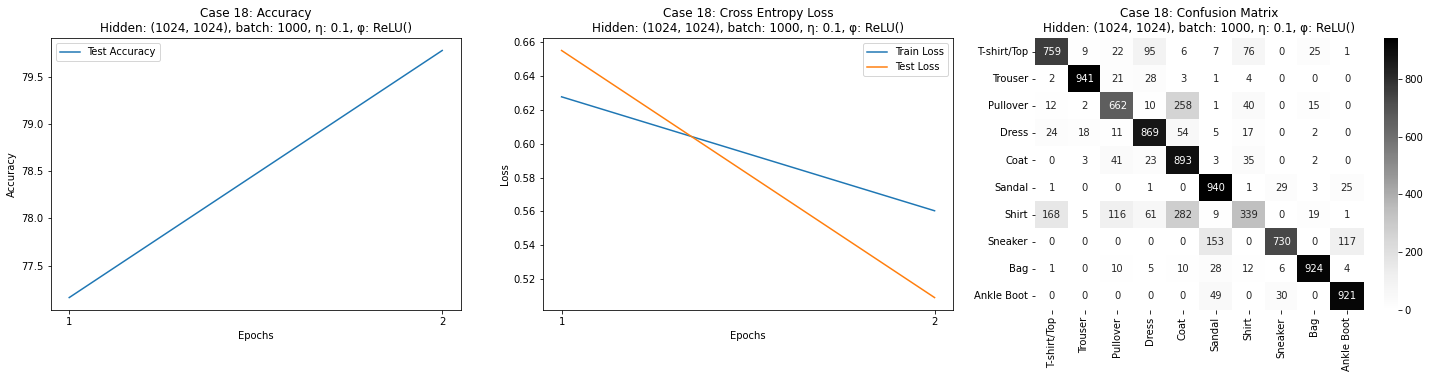

------------------------------------------------------------------------------------------
CASE: 19 Training Started: 01/17/2022 04:36:14
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.6834    Testing Loss: 1.6818    Testing Accuracy: 58.63%
Epoch 2/2  Training Loss: 1.1507    Testing Loss: 1.1781    Testing Accuracy: 68.86%
Completed Case 19/24: 0:00:21.797758 Elapsed



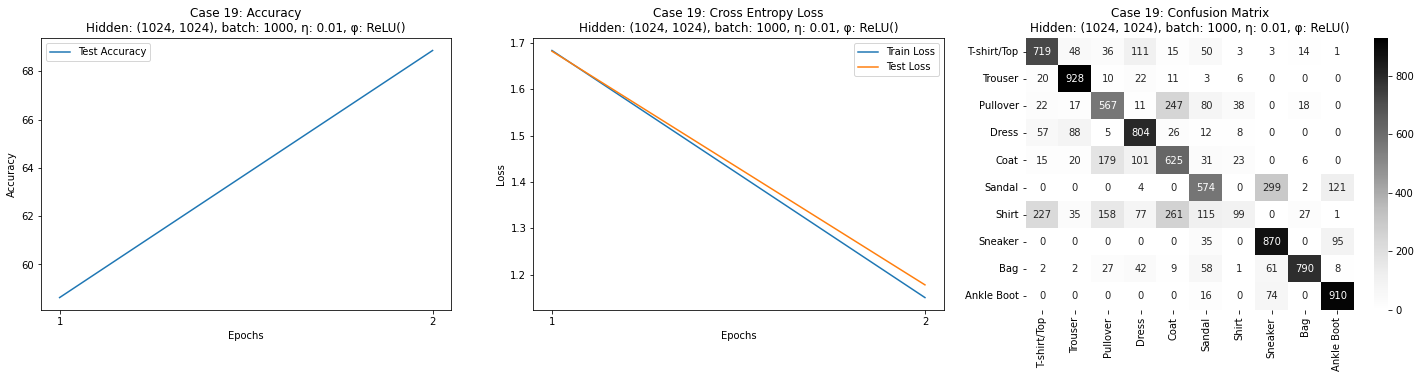

------------------------------------------------------------------------------------------
CASE: 20 Training Started: 01/17/2022 04:36:38
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 2.2482    Testing Loss: 2.2562    Testing Accuracy: 27.64%
Epoch 2/2  Training Loss: 2.2003    Testing Loss: 2.1988    Testing Accuracy: 47.03%
Completed Case 20/24: 0:00:21.725528 Elapsed



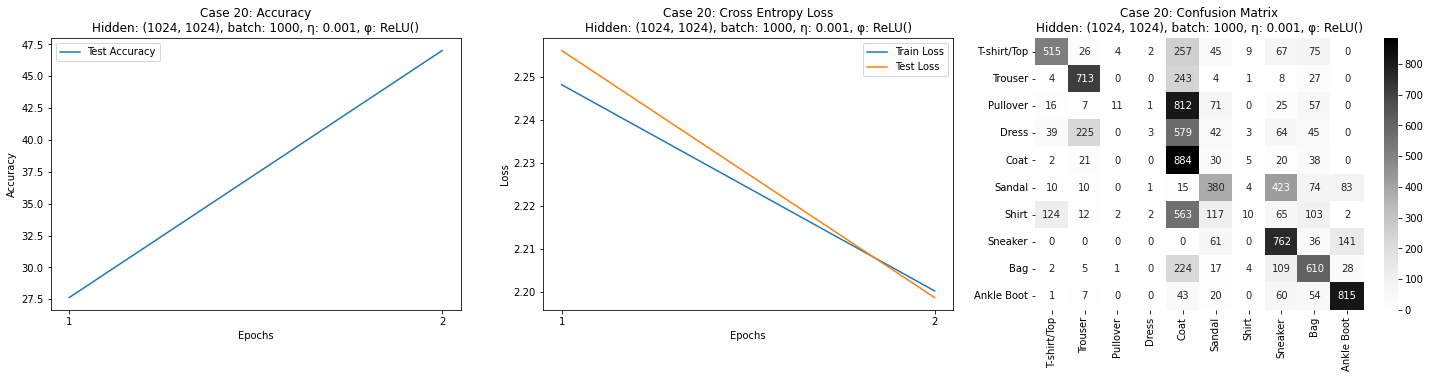

------------------------------------------------------------------------------------------
CASE: 21 Training Started: 01/17/2022 04:37:03
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.4520    Testing Loss: 1.1894    Testing Accuracy: 44.76%
Epoch 2/2  Training Loss: 0.8306    Testing Loss: 0.8004    Testing Accuracy: 66.04%
Completed Case 21/24: 0:00:21.981961 Elapsed



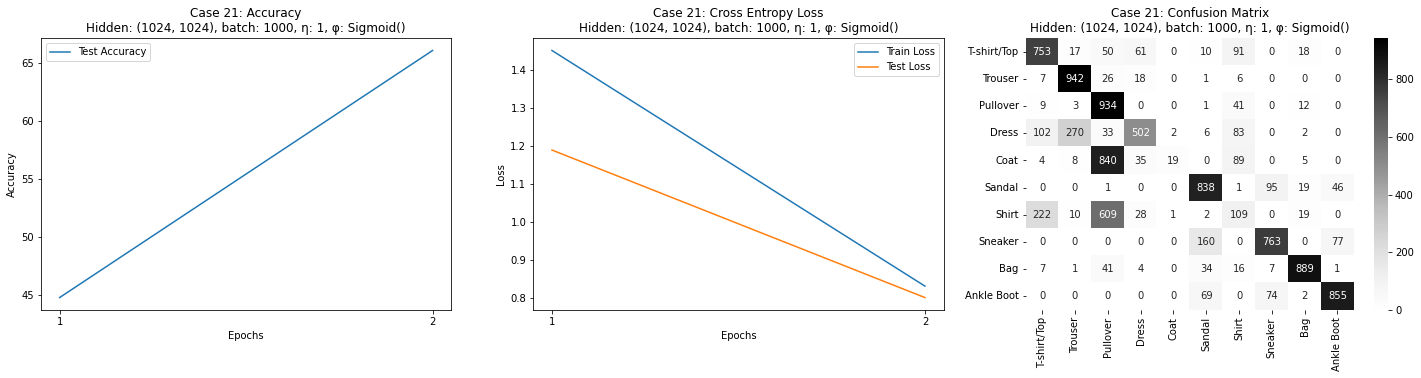

------------------------------------------------------------------------------------------
CASE: 22 Training Started: 01/17/2022 04:37:27
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 2.2912    Testing Loss: 2.2736    Testing Accuracy: 28.39%
Epoch 2/2  Training Loss: 1.7594    Testing Loss: 1.7466    Testing Accuracy: 37.17%
Completed Case 22/24: 0:00:21.456869 Elapsed



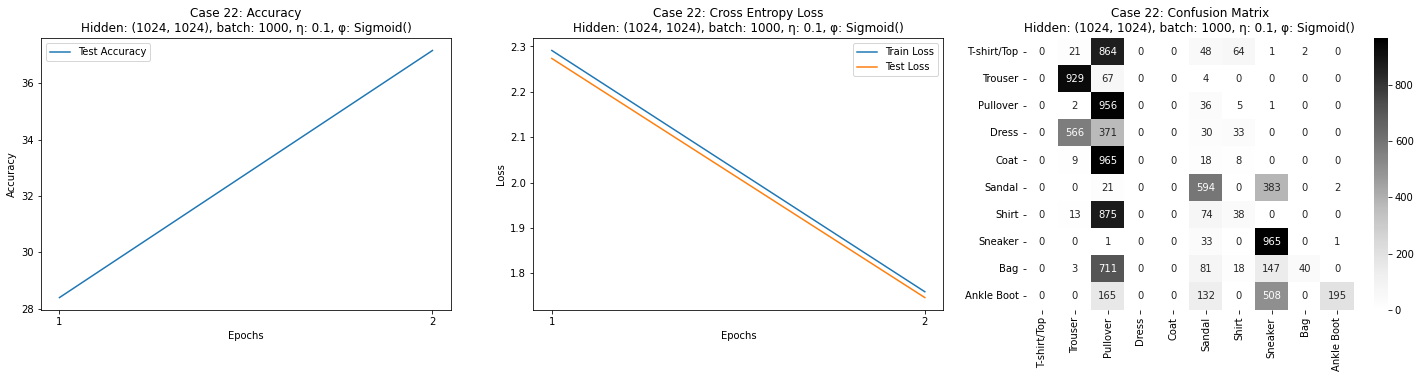

------------------------------------------------------------------------------------------
CASE: 23 Training Started: 01/17/2022 04:37:51
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 2.2878    Testing Loss: 2.2866    Testing Accuracy: 19.9%
Epoch 2/2  Training Loss: 2.2762    Testing Loss: 2.2747    Testing Accuracy: 41.99%
Completed Case 23/24: 0:00:22.116698 Elapsed



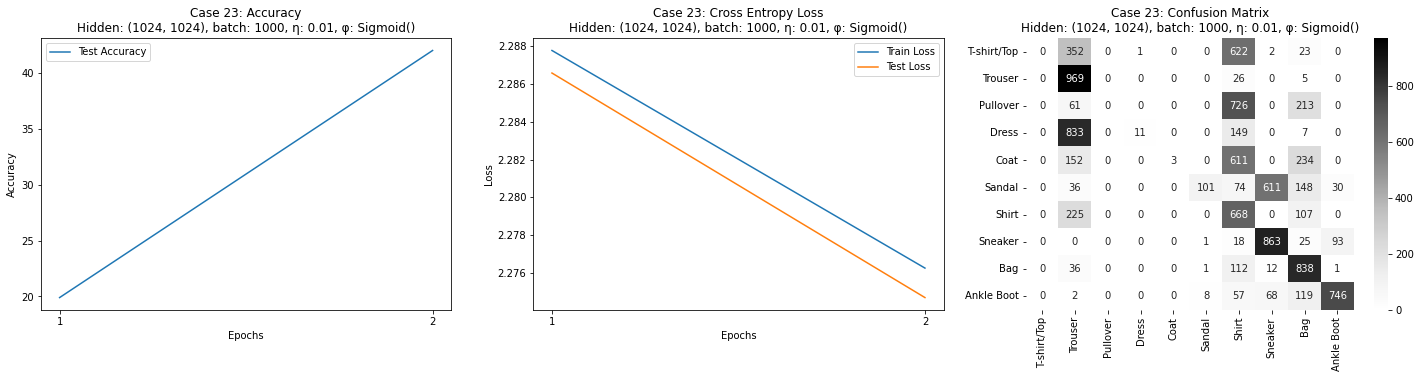

------------------------------------------------------------------------------------------
CASE: 24 Training Started: 01/17/2022 04:38:16
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 2.3008    Testing Loss: 2.3002    Testing Accuracy: 15.14%
Epoch 2/2  Training Loss: 2.2988    Testing Loss: 2.2979    Testing Accuracy: 19.39%
Completed Case 24/24: 0:00:21.534190 Elapsed



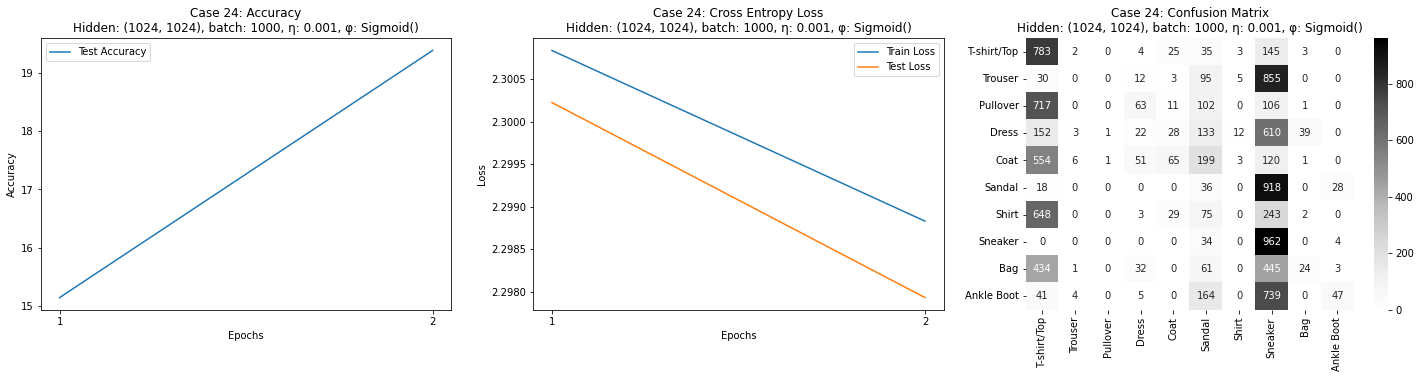

Total Elapsed Time: 0:37:07.277851




In [75]:
import time
import time as timer
import datetime
from datetime import timedelta

start = timer.time()
timestamp_pretty = time.strftime("%m/%d/%Y %H:%M:%S")
timestamp = time.strftime("%Y%m%d-%H%M%S")
print(f"3*4*2=24 Model Training - Started At: {timestamp_pretty}")

hidden_size = (1024, 1024)
momentum = 0
epochs = 2

# for faster testing
# params = {
#     'batch_size': [1],
#     'activation': [nn.ReLU()],
#     'learn_rate': [1, 0.1],
# }

params = {
    'batch_size': [1, 10, 1000],
    'activation': [nn.ReLU(), nn.Sigmoid()],
    'learn_rate': [1, 0.1, 0.01, 0.001],
}

i = 0
for batch_size in params['batch_size']:
    for activation in params['activation']:
        for learn_rate in params['learn_rate']:
            i += 1
            start_iteration = timer.time()
            start_train = datetime.datetime.now()
            start_train_str = start_train.strftime("%m/%d/%Y %H:%M:%S")
            print("------------------------------------------------------------------------------------------")
            print(f"CASE: {i:02d} Training Started: {start_train_str}")
            print("------------------------------------------------------------------------------------------")

            model = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
            model.train(hidden_size=hidden_size, activation=activation,
                            learn_rate=learn_rate, momentum=momentum, epochs=epochs)

            elapsed = (time.time() - start_iteration)
            print(f"Completed Case {i}/24: {str(timedelta(seconds=elapsed))} Elapsed\n")

            display_model_visuals(model=model, hidden_size=hidden_size, title=f"Case {i:02d}");

elapsed = (time.time() - start)
print(f"Total Elapsed Time: {str(timedelta(seconds=elapsed))}\n\n")

#Data Pollution

Pick 9 sets of 1% of images from each of the 10 categories and add them to the other 9 categories.

In [76]:
data_train = pd.read_csv(train_file_path)
data_train.label.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [77]:
df_polluted = pd.DataFrame()

for i in range(10):
    df = data_train.loc[data_train.label == i]
    df = df.sample(frac=0.1)
    for j in range(10):
        if j==i:
            continue
        df.label = j
        df_polluted = df_polluted.append(df)

In [78]:
df_polluted = df_polluted.append(data_train)

In [79]:
# normalize the data and loading them for our model

mean = np.array(df_polluted.iloc[:,1:]).flatten().mean()
std  = np.array(df_polluted.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_train_polluted = FashionMNIST(df_polluted, transform=transf)

## Experiments with the polluted data

--------------------------------------------------------
TestFashionModel.test_part1_polluted: 01/17/2022 05:40:22
--------------------------------------------------------
Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 5.2377    Testing Loss: 0.0011    Testing Accuracy: 70.33%
Epoch 2/2  Training Loss: 0.1081    Testing Loss: 1.2504    Testing Accuracy: 63.06%


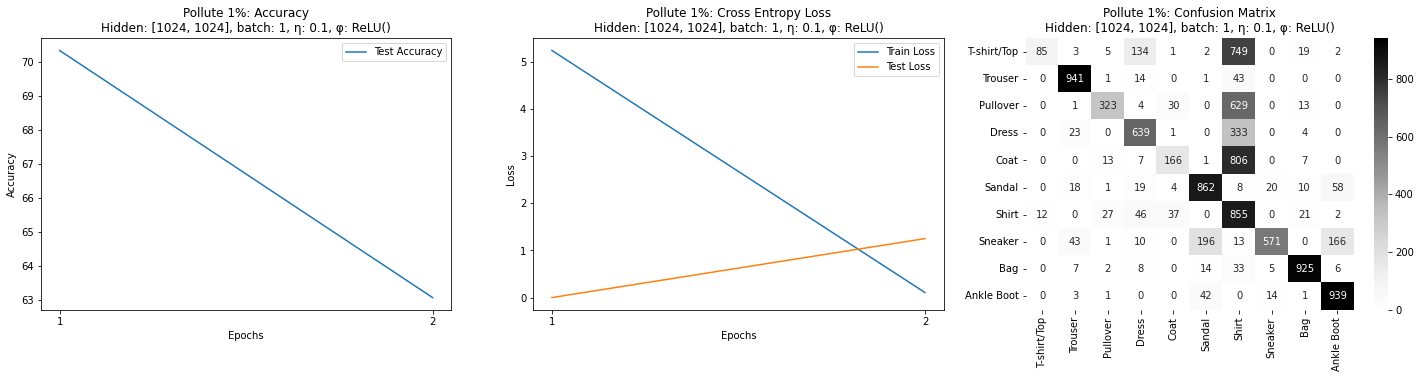

Time taken: 0:06:28.592312 Elapsed




In [80]:
import time
import time as timer
import datetime
from datetime import timedelta

start = timer.time()
timestamp_pretty = time.strftime("%m/%d/%Y %H:%M:%S")
timestamp = time.strftime("%Y%m%d-%H%M%S")
print("--------------------------------------------------------")
print(f"TestFashionModel.test_part1_polluted: {timestamp_pretty}")
print("--------------------------------------------------------")

hidden_size = [1024, 1024]
batch_size = 1
learn_rate = 0.1
activation = nn.ReLU()
momentum = 0
epochs = 2

# Train the model
model_polluted = FashionModel(data_train=data_train_polluted, data_test=data_test, batch_size=batch_size)
model_polluted.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

display_model_visuals(model=model_polluted, hidden_size=hidden_size, title="Pollute 1%")

elapsed = (time.time() - start)
print(f"Time taken: {str(timedelta(seconds=elapsed))} Elapsed\n\n")

# Circular Shift

In [13]:
data_test = pd.read_csv(test_file_path)
data_test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,37,93,72,58,55,63,66,89,159,120,20,0,0,0,0,1,0,0,0,0,0,0,1,0,0,22,67,125,151,168,...,112,115,117,117,113,146,41,0,3,0,0,0,0,0,0,0,1,0,1,76,54,55,51,53,53,55,53,44,38,37,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,0,0,76,36,110,170,78,136,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,...,94,84,70,44,0,36,152,65,110,0,0,0,0,0,0,0,21,57,89,7,0,0,0,0,0,0,0,0,0,0,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,0,1,3,0,14,152,184,158,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,...,219,223,226,239,247,241,224,213,144,0,0,0,0,0,0,1,0,44,232,199,200,190,180,179,185,189,191,185,179,178,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,131,192,79,0,0,0,0,...,13,26,17,8,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [14]:
def shift_right(n):
    right_cols = data_test.iloc[:, -2:]
    left_cols = data_test.iloc[:, 1:-2]
    shifted = pd.concat([right_cols, left_cols], axis=1)
    # shifted = pd.concat([right_cols, left_cols.reindex(right_cols.index)], axis=1)
    shifted.columns = data_test.columns[1:]
    shifted.insert(loc=0, column='label', value=data_test.label)
    return shifted

In [15]:
shifted_df = shift_right(2)

In [16]:
# normalize the data and loading them for our model
mean = np.array(data.iloc[:,1:]).flatten().mean()
std  = np.array(data.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_train = pd.read_csv(train_file_path)
data_test  = FashionMNIST(shifted_df,transform=transf)
data_train = FashionMNIST(data_train,transform=transf)

In [17]:
# Although it looks like I am doing training here, I am not training on the shifted dataset, 
# I am sure I am testing on the shifted dataset. I am testing on all epochs.

hidden_size = [1024, 1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 2

model_2 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_2.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.0048    Testing Loss: 1.2763    Testing Accuracy: 56.07%
Epoch 2/2  Training Loss: 0.6778    Testing Loss: 1.7546    Testing Accuracy: 60.32%


In [64]:
data_test = pd.read_csv(test_file_path)

In [65]:
def shift_down(n):
    down_shifted = data_test.shift(periods=2)
    top_rows = data_test[:2]
    for i in range(2):
        down_shifted.loc[i] = top_rows.loc[i]
    return down_shifted

In [66]:
shifted_df = shift_down(2)
shifted_df = shifted_df.astype(int)

In [68]:
# normalize the data and loading them for our model
mean = np.array(data.iloc[:,1:]).flatten().mean()
std  = np.array(data.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_train = pd.read_csv(train_file_path)
data_test  = FashionMNIST(shifted_df,transform=transf)
data_train = FashionMNIST(data_train,transform=transf)


hidden_size = [1024, 1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 2

model_2 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_2.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.9476    Testing Loss: 0.8301    Testing Accuracy: 71.85%
Epoch 2/2  Training Loss: 0.6172    Testing Loss: 0.7532    Testing Accuracy: 75.64%
